# Exploring temporal and spatial sampling

This Jupyter notebook delves into the temporal trends and availability of variables crucial for calculating turbulent heat fluxes in multiple datasets obtained during the 2019 saildrone Antarctic circumnavigation mission. Leveraging Python libraries such as xarray, matplotlib, and gsw_xarray, the notebook meticulously examines and visualizes the data.

The notebook initiates by loading datasets for saildrones SD1020, SD1022, and SD1023, alongside an ADCP dataset. It then proceeds to calculate wind speed and direction from zonal and meridional wind components for each saildrone dataset, pivotal for turbulent heat flux calculations.

Subsequently, the notebook plots the temporal availability of variables essential for computing turbulent heat fluxes within each dataset. This visualization is instrumental in identifying temporal gaps or periods with missing data, crucial for accurate heat flux estimation.

Moving forward, the notebook scrutinizes the sampling frequency of observations within each dataset. By generating scatter plots and histograms, it illuminates the distribution of sampling intervals, providing critical insights into data collection frequency necessary for turbulent heat flux analysis.

Finally, the notebook explores the spatial distribution of observations by plotting histograms of distances between observations for each dataset. Additionally, it visualizes the relationship between wind speed and distance from the saildrones, shedding light on potential spatial patterns or trends relevant to turbulent heat flux calculations.

Through these meticulous analyses, the notebook aims to uncover both temporal and spatial patterns in the saildrone datasets, facilitating a comprehensive exploration focused on turbulent heat flux estimation.

## Load functions and data

In [1]:
# Enable autoreload extension to automatically reload modules
%load_ext autoreload
%autoreload 1

# Import necessary modules and libraries
from AirSeaFluxCode import AirSeaFluxCode  # Import AirSeaFluxCode class from AirSeaFluxCode module
import xarray as xr  # Import xarray library with alias xr
import gsw_xarray as gsw  # Import gsw_xarray module with alias gsw
import matplotlib.dates as mdates  # Import module for working with dates in matplotlib
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting
import numpy as np  # Import numpy library with alias np for numerical operations
import cartopy.crs as ccrs  # Import cartopy for geospatial data visualization
import cmocean.cm as cmo  # Import colormaps from cmocean for oceanography
from matplotlib.lines import Line2D

# Import my_funcs module for interactive reloading
%aimport my_funcs

# Call update_params function from my_funcs module to update parameters
my_funcs.update_params(fontsize=24)

# Define a function to customize x-axis ticks on a plot
def fix_xticks(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to display month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))  # Format major ticks as abbreviated month (e.g., Jan)
    # Set x-axis label to '2019'
    ax.set_xlabel('2019')

# Define color variables with hexadecimal color codes
c20 = "#C13F89"  # Define color c20
c22 = "#3ec177"  # Define color c22
c23 = "#3e88c1"  # Define color c23
ext = "#a43ec1"  # Define color ext


In [2]:
# Load SD1020 ADCP and dataset, squeeze and swap dimensions
adcp = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')\
        .squeeze().swap_dims({'obs':'time'})
ds20 = xr.open_dataset('../data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc')\
        .squeeze().swap_dims({'obs':'time'})

# Load SD1022 and SD1023 datasets, and set coordinates
ds22 = xr.open_dataset('../data/Sd1022_data_merged.nc').set_coords(['longitude','latitude'])
ds23 = xr.open_dataset('../data/Sd1023_data_merged.nc').set_coords(['longitude','latitude'])

## Calculate wind speed and air-sea fluxes

In [3]:
def calc_ws_wd(ds):
    """
    Calculates wind speed and wind direction from zonal (UWND_MEAN) and meridional (VWND_MEAN) wind components.

    Parameters:
    - ds (xarray.Dataset): Dataset containing zonal and meridional wind components.

    Returns:
    - ds (xarray.Dataset): Dataset with the calculated wind speed and wind direction added as new variables 'wind_speed' and 'wind_direction'.
    """
    # Calculate wind speed using the square root of the sum of squares of zonal and meridional wind components
    ds['wind_speed'] = np.sqrt(ds['UWND_MEAN']**2 + ds['VWND_MEAN']**2)

    # Calculate wind direction using arctan2 function
    ds['wind_direction'] = np.arctan2(ds['VWND_MEAN'], ds['UWND_MEAN']) * (180 / np.pi)
    ds['wind_direction'] = (ds['wind_direction'] + 360) % 360  # Convert negative angles to positive
    
    return ds

In [4]:
# Calculate wind speed and wind direction for SD1020 dataset
ds20 = calc_ws_wd(ds20)

# Calculate wind speed and wind direction for SD1022 dataset
ds22 = calc_ws_wd(ds22)

# Calculate wind speed and wind direction for SD1023 dataset
ds23 = calc_ws_wd(ds23)


## Plot data availability

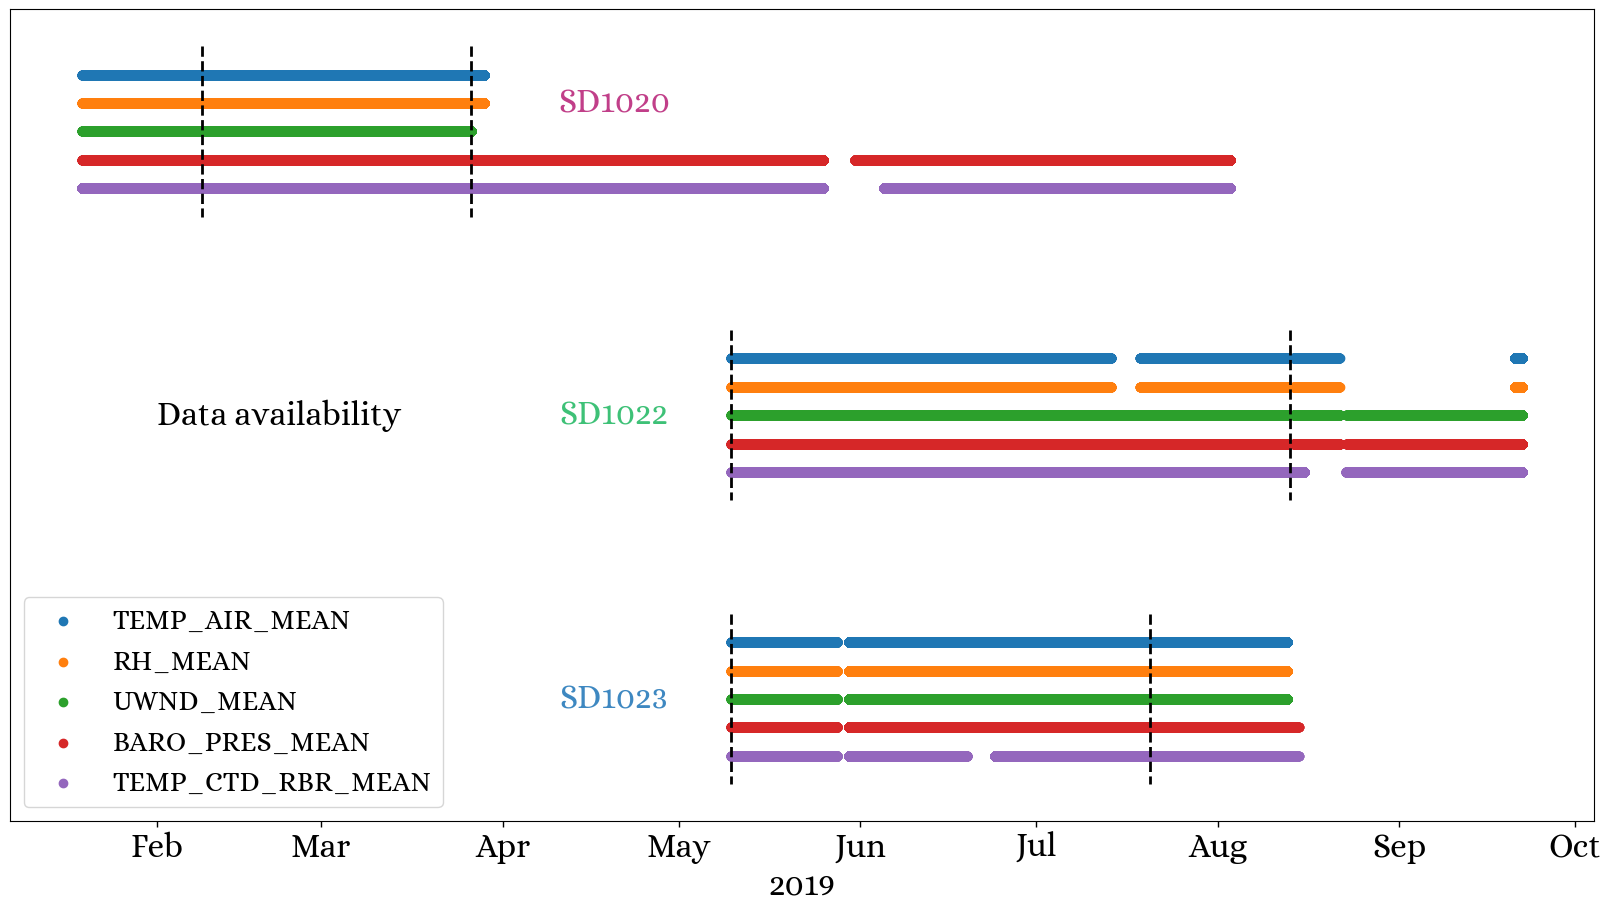

In [5]:
""" 
Summary: This code creates a scatter plot to visualize the time series of multiple variables 
from three datasets (SD1020, SD1022, and SD1023). 
It also highlights the availability of data for each dataset.
""" 

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(16, 9), constrained_layout=True)

# Define variables and colors for plotting
var = ['TEMP_AIR_MEAN', 'RH_MEAN', 'UWND_MEAN', 'BARO_PRES_MEAN', 'TEMP_CTD_RBR_MEAN']  # Variables to plot
c = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']  # Colors for each variable

# Loop through each dataset and set the position (y), start, and end x-values for highlighting data availability
for ds, y, x1, x2 in zip([ds20, ds22, ds23], [3, 2, 1], [29510, 0, 0], [95630, 137287, 100000]):
    # Loop through each variable and plot its data points
    for d, (v, col) in enumerate(zip(var, c)):
        # Mask to select finite values of the variable
        msk = np.where(np.isfinite(ds[v]))[0]
        # Scatter plot of the variable data points
        if y == 3:
            ax.scatter(ds.time.values[msk], [y - 0.1 * d] * len(msk), c=col, label=v)
        else:
            ax.scatter(ds.time.values[msk], [y - 0.1 * d] * len(msk), c=col)

    # Highlight data availability by drawing dashed lines
    ax.plot([ds.time[x1].values, ds.time[x1].values], [y + 0.1, y - d * 0.1 - 0.1], lw=2, ls='--', c='k')  # Start time
    ax.plot([ds.time[x2].values, ds.time[x2].values], [y + 0.1, y - d * 0.1 - 0.1], lw=2, ls='--', c='k')  # End time

# Customize x-axis ticks
fix_xticks(ax)

# Remove y-axis ticks
ax.set_yticks([])

# Add legend for variable labels
ax.legend(loc='lower left', fontsize='small')

# Add text labels for each dataset and data availability
ax.text(np.datetime64("2019-04-20"), 3 - 0.1, 'SD1020', fontweight='bold', c=c20, ha='center', va='center')
ax.text(np.datetime64("2019-04-20"), 2 - 0.2, 'SD1022', fontweight='bold', c=c22, ha='center', va='center')
ax.text(np.datetime64("2019-04-20"), 1 - 0.2, 'SD1023', fontweight='bold', c=c23, ha='center', va='center')
ax.text(np.datetime64("2019-02-01"), 2 - 0.2, 'Data availability', fontweight='bold', c='k', ha='left', va='center')

# Show the plot
plt.show()

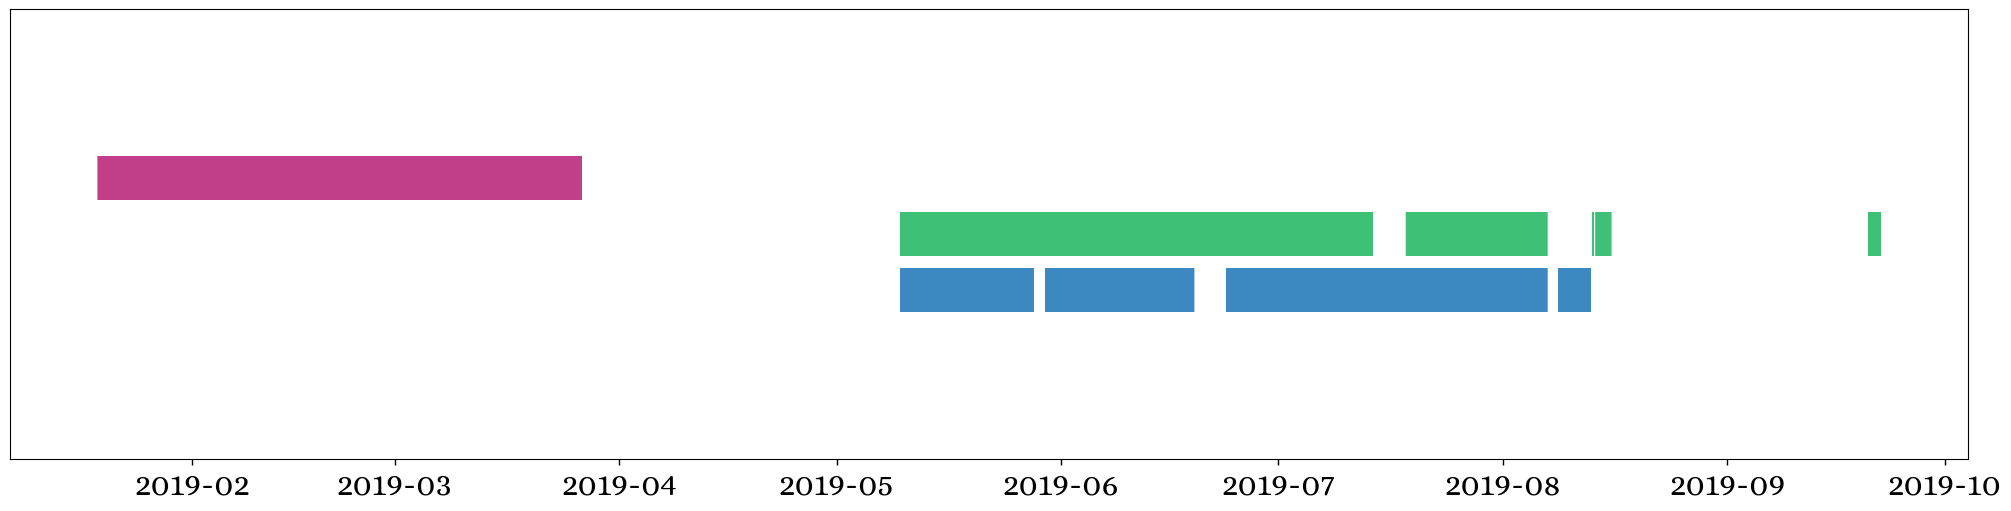

In [6]:
"""
Summary:
    This script creates a time series plot to visualize the availability of multiple variables' data points 
    for three datasets: SD1020, SD1022, and SD1023.

Parameters:
    ds20 (xarray.Dataset): Dataset for SD1020.
    ds22 (xarray.Dataset): Dataset for SD1022.
    ds23 (xarray.Dataset): Dataset for SD1023.

Description:
    The script iterates through each dataset and determines the availability of data points for multiple variables.
    It then creates a time series plot where each vertical line represents the availability of data for all variables
    at a specific time point. The datasets are plotted on separate y-axes to distinguish between them.

    The availability of data is determined by checking if all variables have finite values at each time point.
    If all variables have finite values, a vertical line is plotted at that time point. Otherwise, no line is plotted.

    The plot provides insights into the temporal coverage and gaps in the datasets, helping to identify periods with missing
    or incomplete data.

"""

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(20, 5), constrained_layout=True)

# Initialize lists to store masks and differences in mask indices
masks = []  # List to store masks for each dataset
dm = []  # List to store differences in mask indices for each dataset

# Loop through each dataset and set the position (y) and color for plotting
for ds, y, c in zip([ds20, ds22, ds23], [3, 2, 1], [c20, c22, c23]):
    # Calculate a mask to select indices where all variables have finite values
    msk = np.where(np.logical_and(np.isfinite(ds[var[0]]),
                                  np.logical_and(np.isfinite(ds[var[1]])
                                  ,np.logical_and(np.isfinite(ds[var[2]]),
                                  np.logical_and(np.isfinite(ds[var[3]]), 
                                                 np.isfinite(ds[var[4]]))))))[0]
    # Store the mask for later use
    masks.append(msk)
    # Calculate differences in mask indices
    dm.append(np.diff(msk))

    # Scatter plot to visualize data availability for each dataset
    ax.scatter(ds.time.values[msk], [y] * len(msk), c=c, s=1000, marker='|')

# Remove y-axis ticks
ax.set_yticks([])
ax.set(ylim=(-2,6))
# Show the plot
plt.show()


In [7]:
def plot_sample_freq(ax, bx, ds, c, x1, x2, i, t, y=False):
    """
    Plots the sampling frequency histogram and scatter plot for a dataset.

    Parameters:
        ax (matplotlib.axes.Axes): Axes for scatter plot.
        bx (matplotlib.axes.Axes): Axes for histogram plot.
        ds (xarray.Dataset): Dataset.
        c (str): Color for plots.
        x1 (int): Index of start time.
        x2 (int): Index of end time.
        i (int): Index of the dataset in masks and dm lists.
        t (str): Title for the histogram plot.
        y (bool): Flag to indicate if y-axis label should be displayed (default is False).

    Returns:
        None
    """
    # Scatter plot to visualize sampling frequency
    ax.scatter(ds.time.values[masks[i]][1:], dm[i], marker='s', s=12, c=c)

    # Mask to select indices within the specified time range
    msk = np.where(np.logical_and(ds.time.values[masks[i]] > ds.time.values[x1],
                                  ds.time.values[masks[i]] < ds.time.values[x2]))[0]

    # Histogram plot to visualize sampling frequency distribution
    h = bx.hist(dm[i][msk], bins=np.arange(0, 35, 1), orientation='horizontal', align='left', fc=c, ec="None")

    # Add text labels for histogram bins
    bx.text(h[0][1], h[1][1] + 2, (int(h[0][1])), ha='right', va='center', c='k', fontsize=16)
    bx.text(h[0][5], h[1][5] + 2, (int(h[0][5])), ha='right', va='center', c='k', fontsize=16)
    if h[0][10] > 0:
        bx.text(h[0][10], h[1][10] + 2, (int(h[0][10])), ha='right', va='center', c='k', fontsize=16)

    # Set xscale to log for better visualization of the histogram
    bx.set(xscale='log')

    # Set title for the histogram plot
    bx.set_title(t, loc='right', y=0.82, x=0.975, fontweight='normal', va='center', c=c)

    # Set y-axis label for the scatter plot if specified
    ax.set(ylabel='Sampling frequency (minutes)' if y else '', ylim=(-1, 35))

    # Add vertical dashed lines to indicate start and end time
    ax.axvline(ds.time.values[x1], c='k', ls='--')
    ax.axvline(ds.time.values[x2], c='k', ls='--')

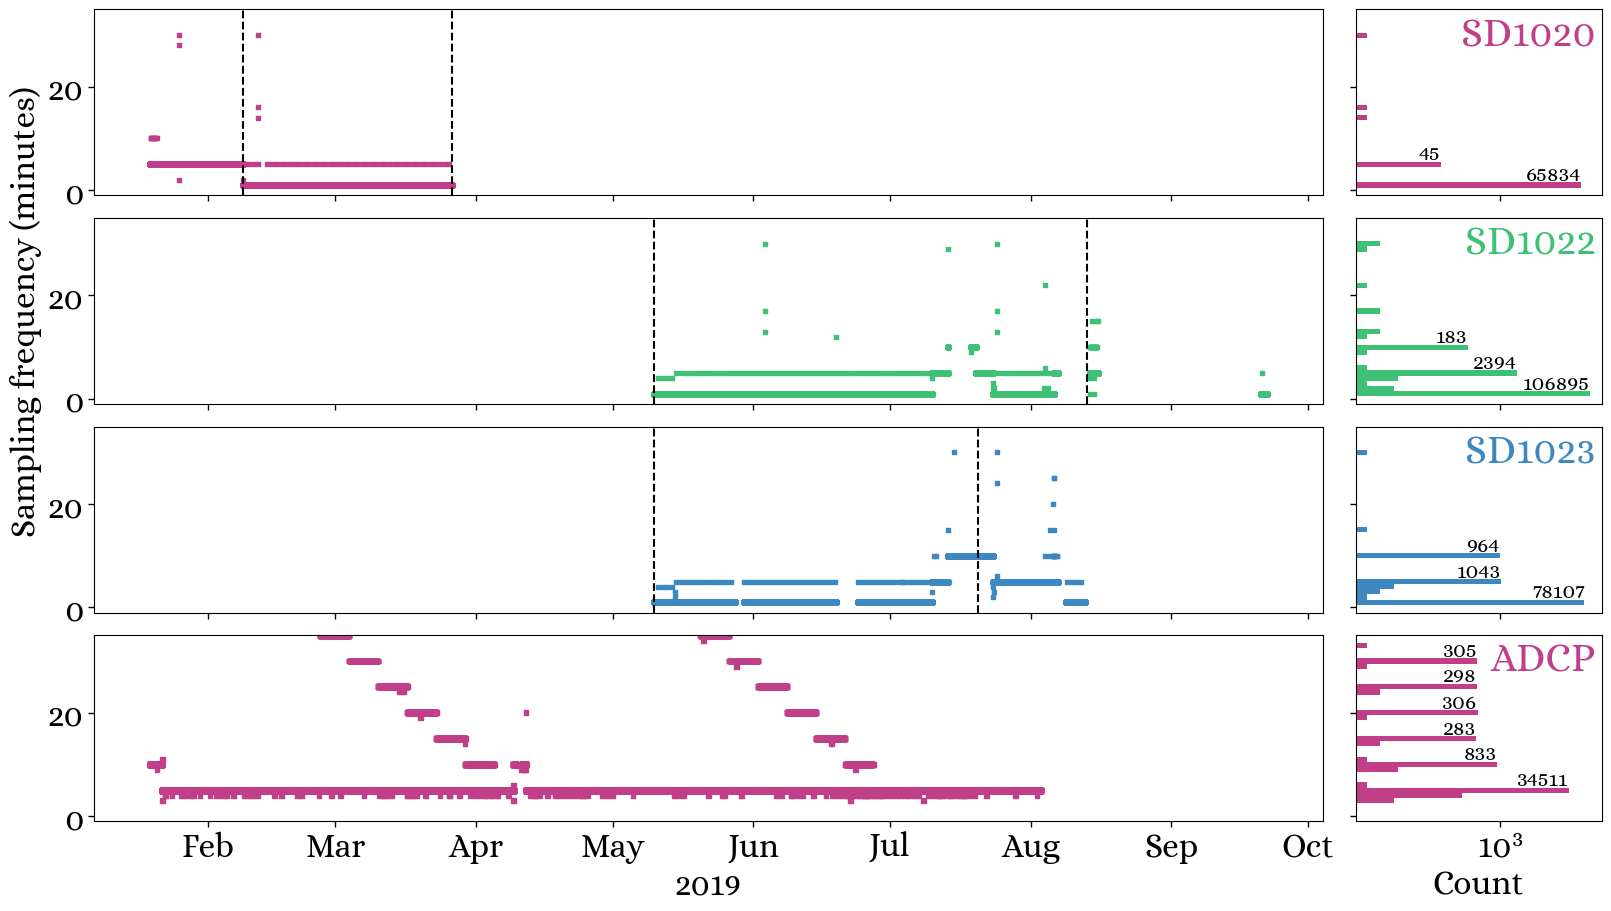

In [8]:
# Create subplots with 4 rows and 2 columns
fig, ax = plt.subplots(4, 2, figsize=(16, 9), width_ratios=[5, 1], sharey='row', sharex='col', constrained_layout=True)

# Plot sampling frequency for SD1020 dataset
plot_sample_freq(ax[0][0], ax[0][1], ds20, c20, 29510, 95630, 0, 'SD1020')

# Plot sampling frequency for SD1022 dataset
plot_sample_freq(ax[1][0], ax[1][1], ds22, c22, 0, 137287, 1, 'SD1022', y=True)

# Plot sampling frequency for SD1023 dataset
plot_sample_freq(ax[2][0], ax[2][1], ds23, c23, 0, 100000 - 1, 2, 'SD1023')

# Calculate sampling frequency for ADCP dataset
dms = (adcp.time.diff('time').values.astype("timedelta64[m]")).astype(int)

# Scatter plot for ADCP sampling frequency
ax[3][0].scatter(adcp.time[1:].values, dms, ls='', marker='s', s=12, c=c20)

# Histogram plot for ADCP sampling frequency
h = ax[3][1].hist(dms, bins=np.arange(0, 35, 1), orientation='horizontal', align='left', fc=c20, ec="None")

# Add text labels for histogram bins
ax[3][1].text(h[0][5], h[1][5] + 2, (int(h[0][5])), ha='right', va='center', c='k', fontsize=16)
ax[3][1].text(h[0][10], h[1][10] + 2, (int(h[0][10])), ha='right', va='center', c='k', fontsize=16)
ax[3][1].text(h[0][15], h[1][15] + 2, (int(h[0][15])), ha='right', va='center', c='k', fontsize=16)
ax[3][1].text(h[0][20], h[1][20] + 2, (int(h[0][20])), ha='right', va='center', c='k', fontsize=16)
ax[3][1].text(h[0][25], h[1][25] + 2, (int(h[0][25])), ha='right', va='center', c='k', fontsize=16)
ax[3][1].text(h[0][30], h[1][30] + 2, (int(h[0][30])), ha='right', va='center', c='k', fontsize=16)

# Set title for ADCP histogram plot
ax[3][1].set_title("ADCP", loc='right', y=0.82, x=0.975, fontweight='normal', va='center', c=c20)

# Set y-axis limit for ADCP scatter plot
ax[3][0].set(ylim=(-1, 35)) # Adjust this to see more bins

# Set x-axis label for ADCP histogram plot
ax[3][1].set(xlabel="Count")

# Customize x-axis ticks for ADCP scatter plot
fix_xticks(ax[3][0])

# Show the plot
plt.show()

## Spatial distribution histograms

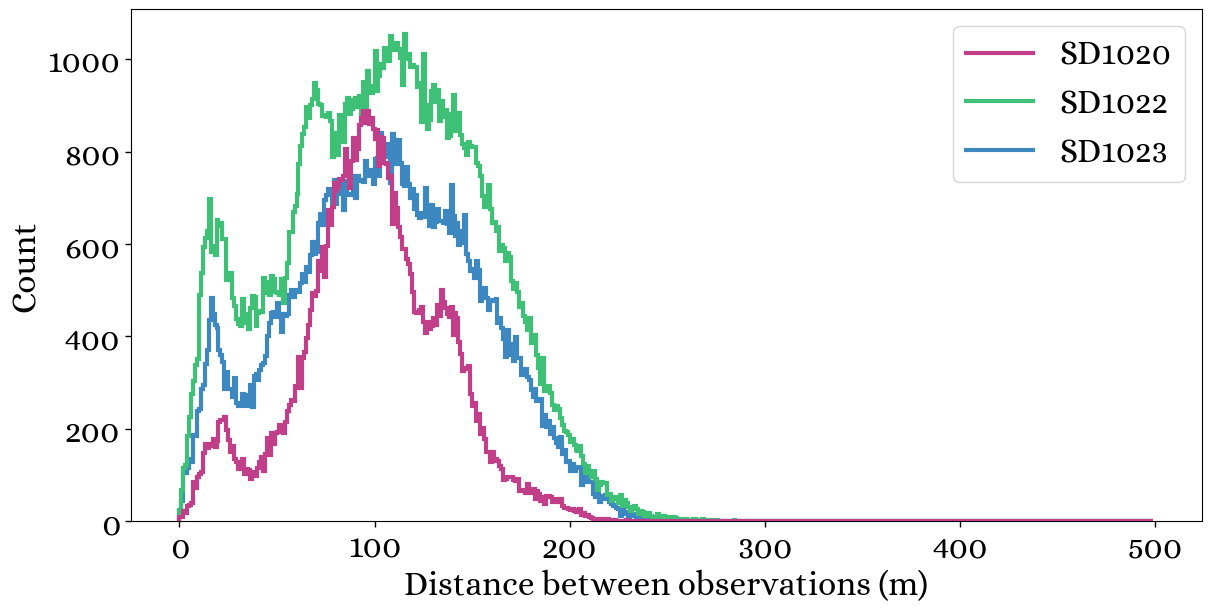

In [9]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

# Plot histograms of distances between observations for each dataset
hist_1 = ax.hist(gsw.distance(ds20.longitude, ds20.latitude)[29510:95630], ec=c20, histtype='step', lw=3,
                 bins=np.arange(0, 500, 1), zorder=3, label='SD1020')  # SD1020 dataset
hist_2 = ax.hist(gsw.distance(ds22.longitude, ds22.latitude)[0:137287], ec=c22, histtype='step', lw=3,
                 bins=np.arange(0, 500, 1), zorder=2, label='SD1022')  # SD1022 dataset
hist_3 = ax.hist(gsw.distance(ds23.longitude, ds23.latitude)[0:100000], ec=c23, histtype='step', lw=3,
                 bins=np.arange(0, 500, 1), zorder=1, label='SD1023')  # SD1023 dataset

# Set labels for the x-axis and y-axis
ax.set(ylabel='Count', xlabel='Distance between observations (m)')

# Manually create Line2D objects for legend handles
legend_handles = [
    Line2D([], [], color=c20, lw=3, label='SD1020'),
    Line2D([], [], color=c22, lw=3, label='SD1022'),
    Line2D([], [], color=c23, lw=3, label='SD1023')
]

# Add legend with custom handles
ax.legend(handles=legend_handles, loc='upper right')

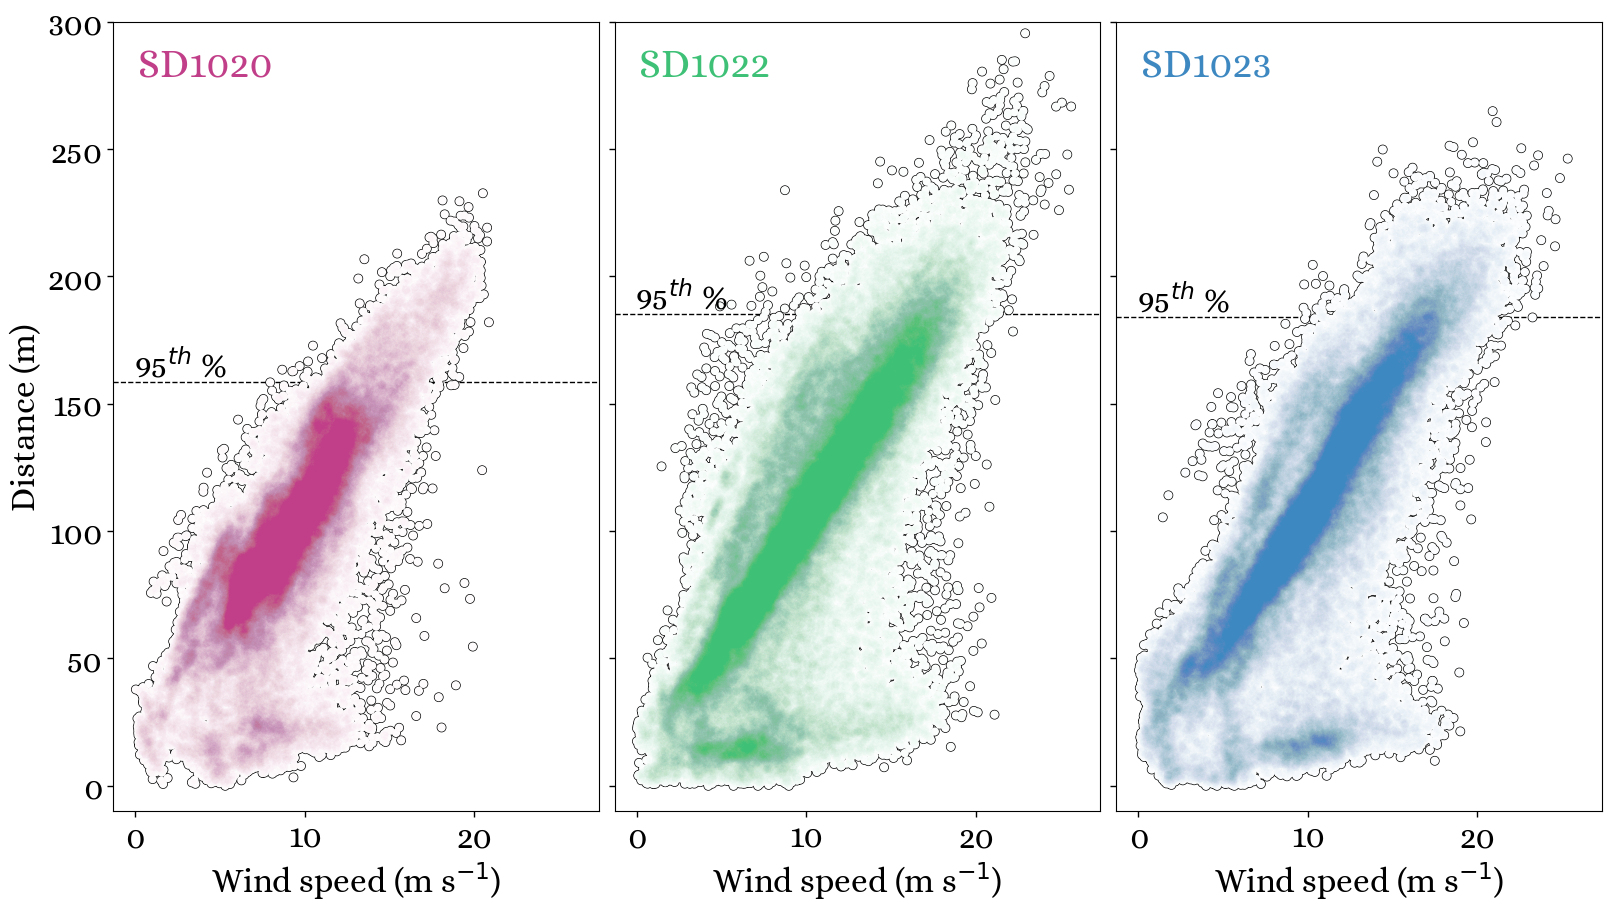

In [10]:
# Create subplots with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(16, 9), constrained_layout=True, sharex=True, sharey=True)

# Iterate over each subplot and dataset to plot
for axs, ds, x1, x2, c, t in zip(ax, [ds20, ds22, ds23], [29510, 0, 0], [95630, 137287, 100000], [c20, c22, c23], ['SD1020', 'SD1022', 'SD1023']):
    # Plot scatter points with wind speed and distance
    axs.scatter(ds['wind_speed'][x1:x2], gsw.distance(ds.longitude, ds.latitude)[x1:x2], fc='None', ec='k', zorder=2)  # Edge
    axs.scatter(ds['wind_speed'][x1:x2], gsw.distance(ds.longitude, ds.latitude)[x1:x2], fc='w', ec='None', zorder=3)    # Middle
    axs.scatter(ds['wind_speed'][x1:x2], gsw.distance(ds.longitude, ds.latitude)[x1:x2], fc=c, ec='None', alpha=0.01, zorder=4)  # Filled
    
    # Set y-axis limit and labels
    axs.set(ylim=(-10, 300), xlabel="Wind speed (m s$^{-1}$)", ylabel="Distance (m)" if x1 != 0 else "")
    
    # Set title for each subplot
    axs.set_title(t, loc='left', x=0.05, y=0.92, fontweight='bold', c=c)
    
    # Add horizontal line at 95th percentile of distance
    axs.axhline(np.nanpercentile(gsw.distance(ds.longitude, ds.latitude)[x1:x2], 95), c='k', ls='--', lw=1, zorder=1)
    
    # Add text annotation for 95th percentile
    axs.text(-0.1, np.nanpercentile(gsw.distance(ds.longitude, ds.latitude)[x1:x2], 95) + 2, '95$^{th}$ %')